# **Classification**

Machine learning : Prédire émission de CO2 à partir des données scrapper via API

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load Data
path = r"C:\Users\jinan\OneDrive\Documents\A5_DIA2\Webscraping\flight-webscrapping\flights-scraper\WebScraping\flights_emissions_data.csv"
df = pd.read_csv(path)
data = df.copy()
print("Data Shape :", data.shape)

# Preprocessing
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].dt.day

X = data.drop(columns=['carbon_emissions', 'date'])
y = data['carbon_emissions']

# Transformation de la variable cible en problème de classification binaire
# Ici, on considère un seuil arbitraire de 450000
# Classe 0 : <= 450000 (faible), Classe 1 : > 450000 (élevée)
y_class = (y > 450000).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)


numeric_features = ['total_duration', 'layovers', 'day']
categorical_features = ['airline', 'airplane']

# Transformer les variables catégorielles en numériques (OneHotEncoder)
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Recherche des meilleurs hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Meilleurs paramètres :", grid_search.best_params_)
best_model = grid_search.best_estimator_

# Prédiction sur le test set avec le best model
y_pred = best_model.predict(X_test)

print("\nClassification Report :\n", classification_report(y_test, y_pred))

Data Shape : (407, 6)
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Meilleurs paramètres : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Classification Report :
               precision    recall  f1-score   support

           0       0.88      0.91      0.89        32
           1       0.94      0.92      0.93        50

    accuracy                           0.91        82
   macro avg       0.91      0.91      0.91        82
weighted avg       0.92      0.91      0.91        82



### Interprétation basée sur les métriques de précision, rappel et F1-score :

1. **Classe 0** :
   - **Précision** : 88% des prédictions pour la classe 0 sont correctes. Cela signifie que 12% des prédictions pour la classe 0 sont en réalité des erreurs (faux positifs).
   - **Rappel** : 91% des véritables instances de classe 0 ont été correctement identifiées. Cela montre que le modèle manque seulement 9% des exemples réels de cette classe (faux négatifs).
   - **F1-score** : 0.89, indiquant un bon équilibre entre précision et rappel pour cette classe.

2. **Classe 1** :
   - **Précision** : 94%, montrant que le modèle est très précis pour la classe 1 (faible proportion de faux positifs).
   - **Rappel** : 92%, indiquant que le modèle identifie correctement 92% des instances réelles de classe 1, en manquant 8%.
   - **F1-score** : 0.93, démontrant un excellent équilibre entre précision et rappel pour cette classe.

### Conclusion :
Le modèle est performant pour les deux classes, avec des scores de précision, de rappel et de F1-score élevés, particulièrement pour la classe 1. Cela indique une bonne capacité à prédire correctement les deux classes tout en minimisant les erreurs.

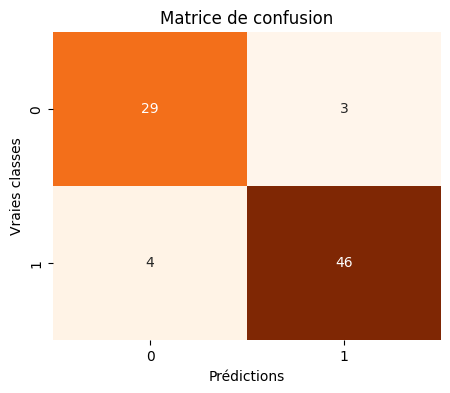

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.show()

### Interprétation de la matrice de confusion :

1. **Vrais positifs (classe 1 correctement prédite)** :  
   - **46** instances de la classe 1 ont été correctement prédites comme étant de classe 1. Cela reflète une bonne performance du modèle pour identifier la classe 1.

2. **Faux positifs (classe 0 prédit comme 1)** :  
   - **3** instances de la classe 0 ont été incorrectement classées comme classe 1, ce qui montre une petite proportion d'erreurs de ce type.

3. **Faux négatifs (classe 1 prédit comme 0)** :  
   - **4** instances de la classe 1 ont été mal classées comme classe 0. Cela indique que le modèle manque quelques exemples de classe 1.

4. **Vrais négatifs (classe 0 correctement prédite)** :  
   - **29** instances de la classe 0 ont été correctement prédites comme classe 0. Cela montre que le modèle est performant pour la classe 0 également.

### Conclusion : 
- Le modèle est globalement performant, comme en témoigne le grand nombre de prédictions correctes (29 pour la classe 0 et 46 pour la classe 1). 
- Les erreurs (3 faux positifs et 4 faux négatifs) sont faibles, ce qui reflète une bonne précision et un bon rappel. 
- Les performances pour les deux classes sont bien équilibrées, ce qui est cohérent avec les scores de précision, rappel, et F1-score observés précédemment.

In [12]:
# Features immportances

# Récupération du pipeline final
best_pipeline = grid_search.best_estimator_

# Accès au preprocessur
preprocessor = best_pipeline.named_steps['preprocessing']
# Récupération du transformer OneHotEncoder pour les colonnes catégorielles
ohe = preprocessor.named_transformers_['cat']

numeric_features = ['total_duration', 'layovers', 'day']
categorical_features = ['airline', 'airplane']

# ohe.categories_ est une liste de listes, chaque sous-liste correspond à une feature catégorielle
ohe_feature_names = []
for cat_col, cat_values in zip(categorical_features, ohe.categories_):
    for val in cat_values:
        ohe_feature_names.append(f"{cat_col}={val}")

# Combiner noms numériques et OHE
all_feature_names = numeric_features + ohe_feature_names

# Récupérer l'importance des features du RandomForest
importances = best_pipeline.named_steps['classifier'].feature_importances_


feature_importances_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
})
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

print(feature_importances_df)


                               feature  importance
0                       total_duration    0.399091
2                                  day    0.156927
10                   airline=Lufthansa    0.060545
15            airline=Turkish Airlines    0.055301
7                     airline=Gulf Air    0.048210
16                     airline=easyJet    0.037392
31                    airplane=Unknown    0.034326
22    airplane=Airbus A321 (Sharklets)    0.028456
8                          airline=ITA    0.026875
14                       airline=SWISS    0.026163
1                             layovers    0.024256
23             airplane=Airbus A321neo    0.014580
21                airplane=Airbus A321    0.012937
6                     airline=Emirates    0.010311
18                airplane=Airbus A319    0.010030
4                   airline=Air France    0.009028
26                airplane=Airbus A380    0.009022
19                airplane=Airbus A320    0.008557
24                airplane=Airb

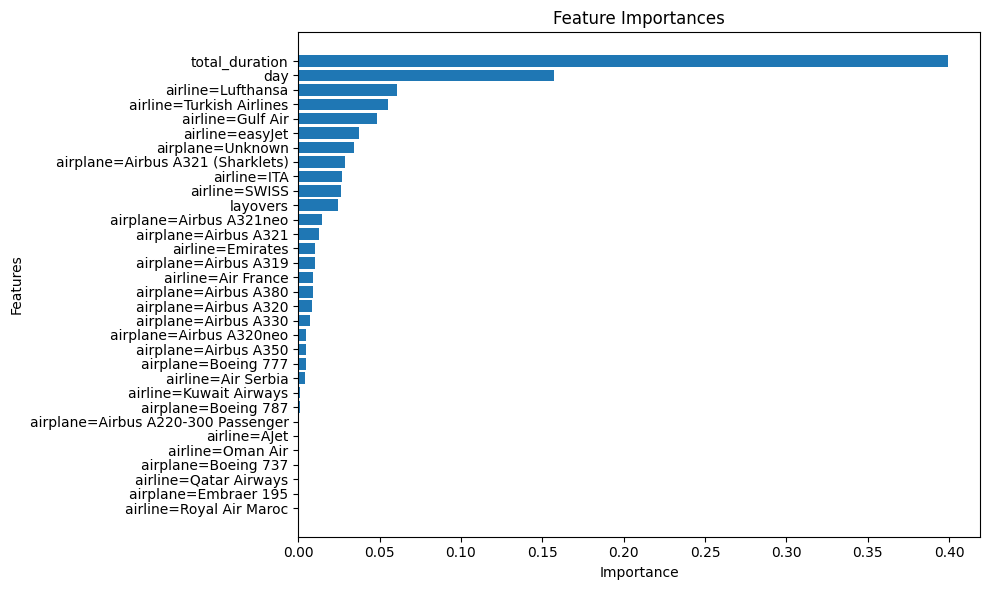

In [13]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


### Analyse des variables influençant les prédictions de CO₂ :

1. **`total_duration` :**
   - La **durée totale du vol** est la caractéristique la plus influente. Cela s'explique par le fait que plus un vol est long, plus il consomme de carburant, ce qui entraîne une augmentation des émissions de CO₂.

2. **`day` :**
   - Le **jour** peut avoir un impact indirect sur les émissions de CO₂, probablement parce qu'il est lié à la demande des vols ou à la saturation des itinéraires. Des jours avec plus de trafic peuvent affecter les routes ou les modèles d'avions utilisés.

3. **Compagnies aériennes :**
   - Les compagnies comme **Lufthansa**, **Turkish Airlines**, ou **Gulf Air** figurent parmi les caractéristiques importantes. Cela peut refléter des différences dans les pratiques opérationnelles, comme l'efficacité énergétique de leur flotte, la fréquence des vols ou le type d'appareils qu'elles utilisent.

4. **Types d'avions :**
   - Les modèles spécifiques d’avions, tels que **Airbus A321neo** ou **Airbus A321 (Sharklets)**, influencent également les émissions. Cela est dû à la variation de l’efficacité énergétique entre les modèles : les avions plus récents et optimisés pour la consommation de carburant, comme le **A321neo**, émettent généralement moins de CO₂ par passager.

5. **Escale (layovers) :**
   - Les **escales** affectent les émissions de CO₂ car elles impliquent des phases supplémentaires de décollage et d’atterrissage, qui consomment beaucoup de carburant, augmentant ainsi les émissions.

---

### Conclusion :
Le graphique montre que les émissions de **CO₂** sont principalement influencées par la durée des vols, suivie par des facteurs comme le modèle d’avion et la compagnie aérienne. Les modèles récents et les vols directs semblent réduire les émissions, ce qui reflète bien les tendances observées dans l'industrie pour réduire l'empreinte carbone.